#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [1]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 6s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [3]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [81]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [82]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [83]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [84]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

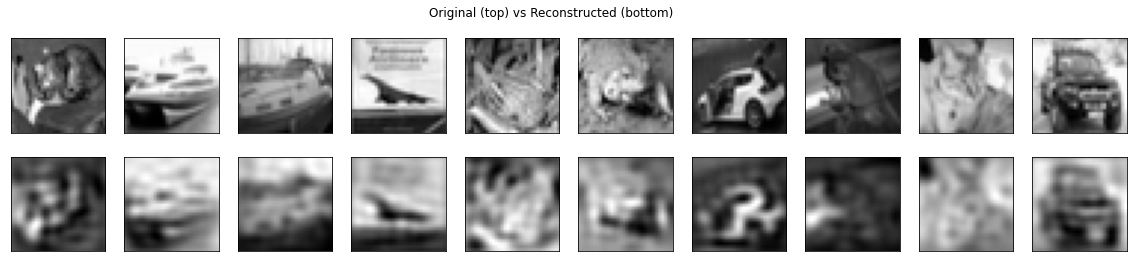

In [85]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

Test with different ENCODING_DIM values

Encoding dim: 32
Training mse: 0.00980
Test mse:	  0.00984


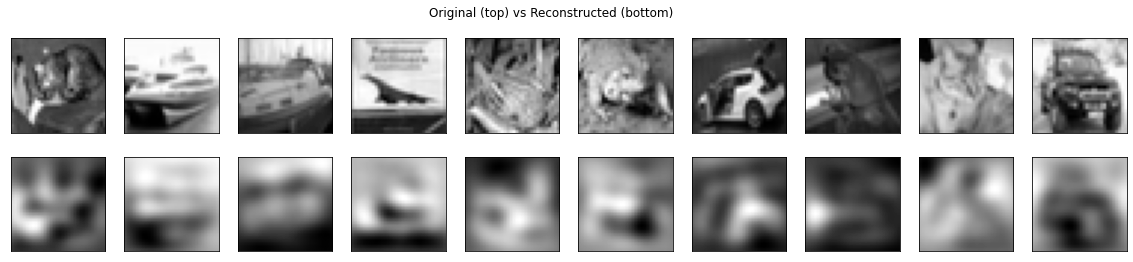

Encoding dim: 64
Training mse: 0.00628
Test mse:	  0.00631


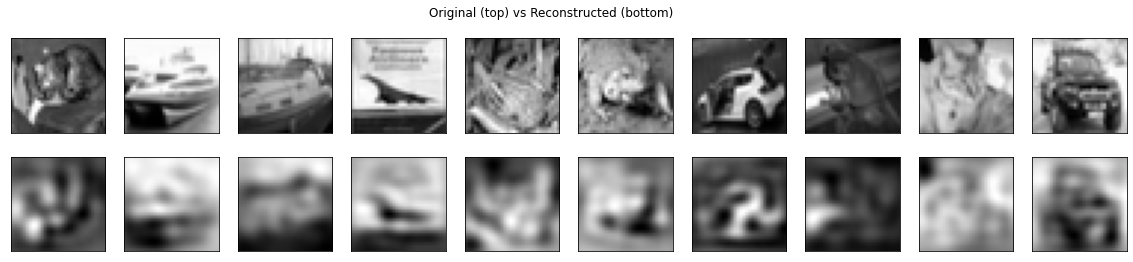

Encoding dim: 128
Training mse: 0.00349
Test mse:	  0.00353


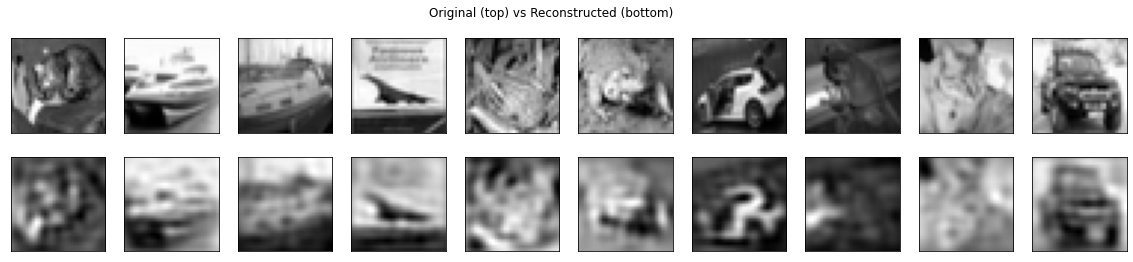

Encoding dim: 256
Training mse: 0.00150
Test mse:	  0.00153


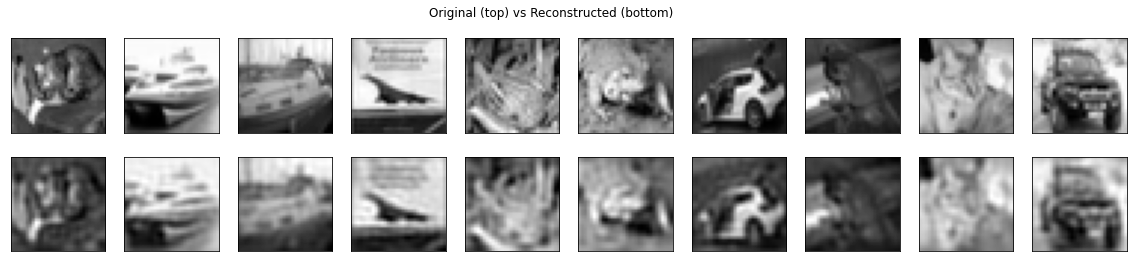

Encoding dim: 512
Training mse: 0.00037
Test mse:	  0.00038


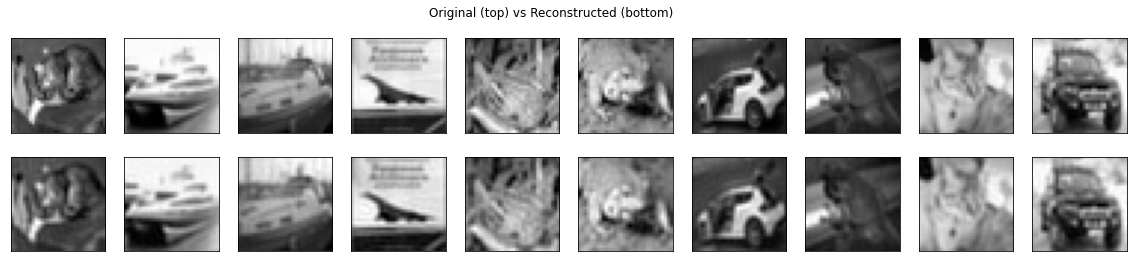

In [68]:
encoding_dims = [32, 64, 128, 256, 512]

for encoding_dim in encoding_dims:

  U_k = SVD(x_train, encoding_dim)

  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)

  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)

  mse_train = ((x_train - x_training_reco)**2).mean()
  mse_test = ((x_test - x_test_reco)**2).mean()

  print(f"Encoding dim: {encoding_dim}")
  print("Training mse: %.5f" % ( mse_train))
  print("Test mse:\t  %.5f" % ( mse_test))

  plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_ 

By varying the `ENCODING_DIM` we change the size of the compressed version of the input data.

With higher values of the encoding size we obtain better images reconstructions and subsequently lower MSE values for both the training set and the test set. With  `ENCODING_DIM = 512` we obtain images that are nearly indistinguishable from the original ones. (Original images are represented by flattened vectors of size 1024)

With smaller values of the encoding size we obtain images with a blurry effect.
The MSE values then are higher for both the training set and the test set. The trade-off for using smaller encoding sizes (which require less memory) is that we lose some information that might be useful for reconstructing the images after the compression phase

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [168]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]     # INPUT_DIM = 1024

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

Print the model summary.

In [169]:
autoencoder.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_82 (Dense)            (None, 256)               262400    
                                                                 
 dense_83 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [170]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=64, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
625/625 [==============================] - 7s 11ms/step - loss: 0.0186 - val_loss: 0.0078
Epoch 2/15
625/625 [==============================] - 7s 10ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 3/15
625/625 [==============================] - 6s 10ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 4/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 5/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 6/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/15
625/625 [==============================] - 6s 10ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/15
625/625 [==============================] - 6s 10ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 9/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0021 - val_loss: 0

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [171]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0020 - 705ms/epoch - 2ms/step
Test mse: 0.00196


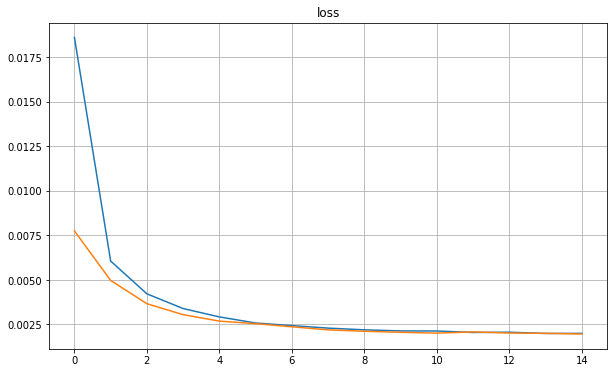

In [172]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

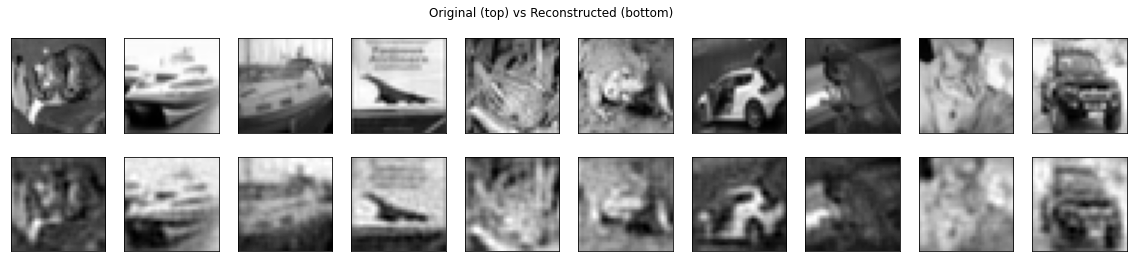

In [173]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_

Test MSE: 
* SVD (`ENCODING_DIM = 256`): 0.00153
* Shallow Linear Autoencoder: 0.00196

I was able to achieve similar performance to the SVD, with the Shallow Linear Autoencoder, by reducing the batch size (from 512 to 64) and by using the default value for the learning rate of the Adam optimization function.

We learned during lectures that when the decoder is linear and the loss function is the MSE, an undercomplete autoencoder learns to span the same subspace as PCA.  
In this notebook we used Singular Value Decomposition (SVD), that is a standard linear dimensionality reduction method similar to PCA.  
I assume that, since both PCA and SVD have a similar behavior, the same relation that exists between linear autoencoders and PCA, stands also between linear autoencoders and SVD.

Given that assumption, it make sense that our Shallow Linear Autoencoder has a similar performance to the SVD.  
The main difference between the two methods is that the SVD is a closed form expression (that gives us immediately the best solution), while the Shallow Linear Autoencoder requires a certain number of iterations to converge to its optimal solution.

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


In [212]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "model_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_105 (Dense)           (None, 256)               262400    
                                                                 
 dense_106 (Dense)           (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


In [213]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=64, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
625/625 [==============================] - 6s 10ms/step - loss: 0.0177 - val_loss: 0.0080
Epoch 2/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 3/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0051 - val_loss: 0.0045
Epoch 4/15
625/625 [==============================] - 6s 10ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/15
625/625 [==============================] - 6s 10ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 6/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 7/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/15
625/625 [==============================] - 6s 9ms/step - loss: 0.0030 - val_loss: 0.0

313/313 - 1s - loss: 0.0027 - 681ms/epoch - 2ms/step
Test mse: 0.00271


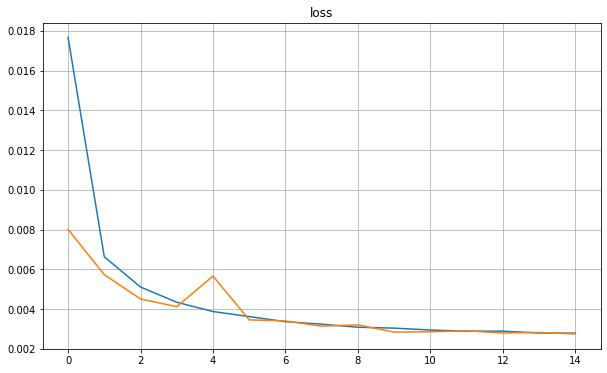

In [214]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

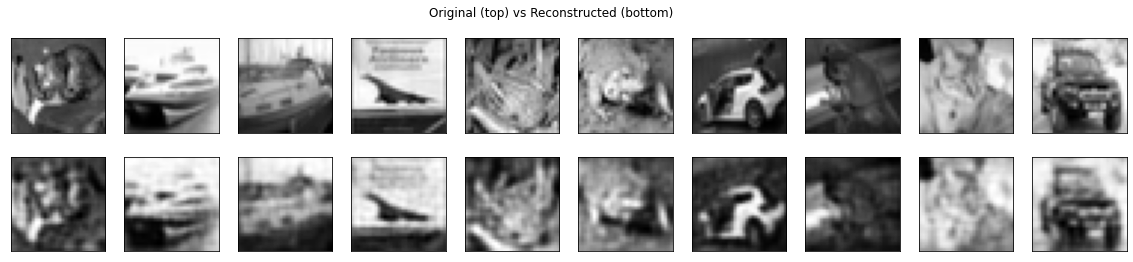

In [215]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

In [216]:
x_test[0]

array([0.41699347, 0.41437906, 0.43398693, ..., 0.29411766, 0.32287583,
       0.25882354], dtype=float32)

__COMMENTS:__

Test MSE: 
* Shallow Linear Autoencoder: 0.00196
* Shallow Non-Linear Autoencoder: 0.00271

In the end I used the _tanh_ as the decoder activation function and the _sigmoid_ as the decoder activation function. With this configuration I was able to achieve the best result, compared with other non-linear activation functions.

The _sigmoid_ returns a value between 0 and 1, that is also the range of values of the pixels in our images.

We know that nonlinear autoencoders, in theory, should be able to learn more powerful nonliner generalization of PCA. In our case that didn't happen and the Shallow Non-Linear Autoencoder was not able to outperform the Linear one. Possibly with a higher number of epochs the Non-Linear model could could have matched the performances

The better performance of the Linear model should be due to the fact that our input space fairly simple (composed by gray-scale images) and the linear functions were good enough to learn a convex manifold.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [112]:
INPUT_DIM = x_train.shape[-1]

ENCODING_DIM = 128

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

encoder_1 = tf.keras.layers.Dense(512, activation="selu")(input_img)
encoder_2 = tf.keras.layers.Dense(256, activation="selu")(encoder_1)
encoder_3 = tf.keras.layers.Dense(ENCODING_DIM, activation="selu")(encoder_2)

decoder_1 = tf.keras.layers.Dense(256, activation="selu")(encoder_3)
decoder_2 = tf.keras.layers.Dense(512, activation="selu")(decoder_1)
decoder_3 = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoder_2)

autoencoder = tf.keras.models.Model(input_img, decoder_3) 

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [113]:
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_60 (Dense)            (None, 512)               524800    
                                                                 
 dense_61 (Dense)            (None, 256)               131328    
                                                                 
 dense_62 (Dense)            (None, 128)               32896     
                                                                 
 dense_63 (Dense)            (None, 256)               33024     
                                                                 
 dense_64 (Dense)            (None, 512)               131584    
                                                                 
 dense_65 (Dense)            (None, 1024)              525

In [114]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 9s 27ms/step - loss: 0.0175 - val_loss: 0.0105
Epoch 2/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 3/15
313/313 [==============================] - 9s 29ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 4/15
313/313 [==============================] - 8s 27ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/15
313/313 [==============================] - 8s 26ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 6/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 7/15
313/313 [==============================] - 8s 27ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 8/15
313/313 [==============================] - 8s 27ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 9/15
313/313 [==============================] - 9s 27ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0055 - val_lo

313/313 - 1s - loss: 0.0050 - 1s/epoch - 4ms/step
test mse: 0.00500


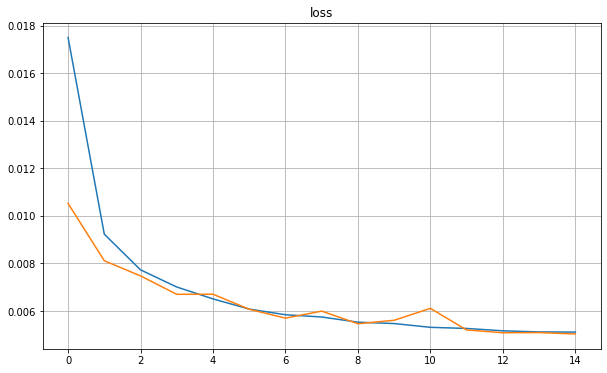

In [115]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

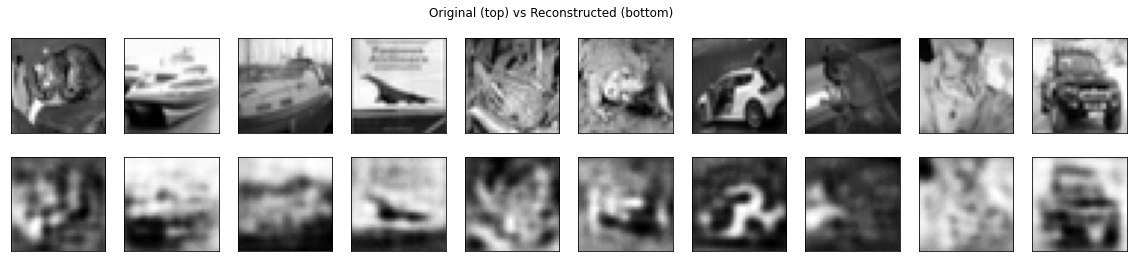

In [116]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

__COMMENT:__ 

I achieved the better results using the following architecture:
* encoding layers (`INPUT_DIM->512->256->128`)
* decoding layers (`256->512->INPUT_DIM`)

I used the _sigmoid_ activation function for the output layer and the _selu_ for all the others. I also used a lower value for the learning rate.  
It achieved slightly better performance compared with the shallow linear autoencoder, but using more than double the parameters.

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [133]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

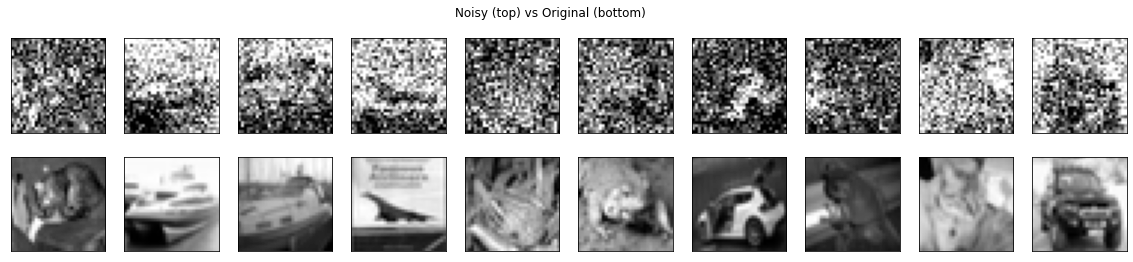

In [140]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [141]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 128

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='selu')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [142]:
autoencoder.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_74 (Dense)            (None, 128)               131200    
                                                                 
 dense_75 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [143]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 15, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0269 - val_loss: 0.0150
Epoch 2/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 3/15
313/313 [==============================] - 3s 9ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 4/15
313/313 [==============================] - 3s 9ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 5/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 6/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 7/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 8/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 9/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 10/15
313/313 [==============================] - 3s 8ms/step - loss: 0.0104 - val_loss: 0.0107

313/313 - 1s - loss: 0.0105 - 535ms/epoch - 2ms/step
Test mse: 0.01049


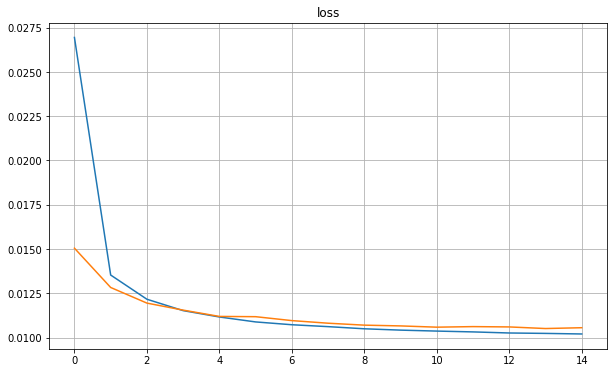

In [144]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

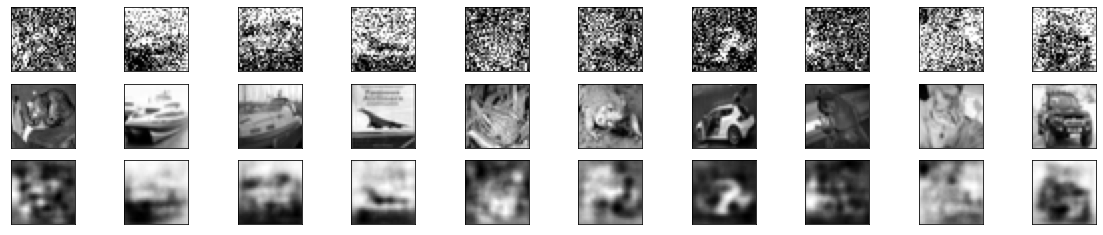

In [146]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [147]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

1654784/1641221 [==============================] - 0s 0us/step


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [148]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [149]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 90, 50)            7550      
                                                                 
 time_distributed (TimeDistr  (None, 90, 100)          5100      
 ibuted)                                                         
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [150]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 64ms/step - loss: 0.1972 - categorical_accuracy: 0.1350 - val_loss: 0.1004 - val_categorical_accuracy: 0.3667
Epoch 2/50
79/79 [==============================] - 4s 57ms/step - loss: 0.0806 - categorical_accuracy: 0.4278 - val_loss: 0.0708 - val_categorical_accuracy: 0.4613
Epoch 3/50
79/79 [==============================] - 5s 57ms/step - loss: 0.0663 - categorical_accuracy: 0.4893 - val_loss: 0.0626 - val_categorical_accuracy: 0.5105
Epoch 4/50
79/79 [==============================] - 5s 58ms/step - loss: 0.0589 - categorical_accuracy: 0.5328 - val_loss: 0.0578 - val_categorical_accuracy: 0.5350
Epoch 5/50
79/79 [==============================] - 5s 58ms/step - loss: 0.0534 - categorical_accuracy: 0.5624 - val_loss: 0.0514 - val_categorical_accuracy: 0.5692
Epoch 6/50
79/79 [==============================] - 5s 59ms/step - loss: 0.0477 - categorical_accuracy: 0.5918 - val_loss: 0.0456 - val_categorical_accuracy: 0.5927
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0104 - categorical_accuracy: 0.9481 - 354ms/epoch - 9ms/step
categorical_accuracy: 94.81%


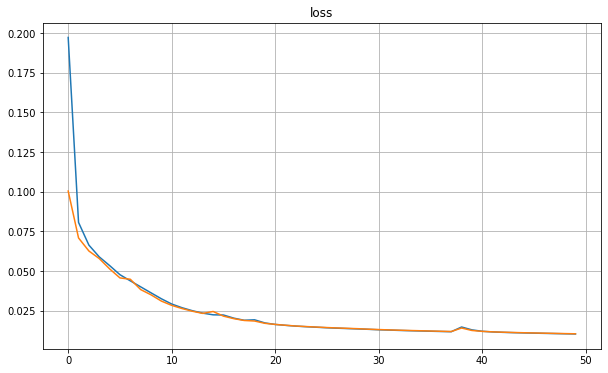

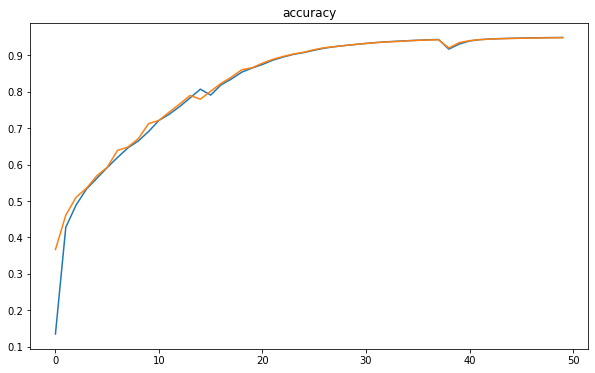

In [151]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [152]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a my <oov> film in just about <oov> <oov> <oov> <oov> this some other <oov> have <oov> story it <oov> it <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> for of <oov> and i <oov> <oov> br <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [153]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))

encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)
decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_1 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [154]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 10s 107ms/step - loss: 0.0441 - categorical_accuracy: 0.4213 - val_loss: 0.0373 - val_categorical_accuracy: 0.4667
Epoch 2/50
79/79 [==============================] - 8s 95ms/step - loss: 0.0359 - categorical_accuracy: 0.4802 - val_loss: 0.0349 - val_categorical_accuracy: 0.4882
Epoch 3/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0326 - categorical_accuracy: 0.4982 - val_loss: 0.0311 - val_categorical_accuracy: 0.4896
Epoch 4/50
79/79 [==============================] - 8s 97ms/step - loss: 0.0286 - categorical_accuracy: 0.4986 - val_loss: 0.0269 - val_categorical_accuracy: 0.4925
Epoch 5/50
79/79 [==============================] - 8s 97ms/step - loss: 0.0243 - categorical_accuracy: 0.5288 - val_loss: 0.0222 - val_categorical_accuracy: 0.6010
Epoch 6/50
79/79 [==============================] - 9s 110ms/step - loss: 0.0196 - categorical_accuracy: 0.6716 - val_loss: 0.0176 - val_categorical_accuracy: 0.7276
Epoch 7

40/40 - 1s - loss: 2.5569e-05 - categorical_accuracy: 1.0000 - 557ms/epoch - 14ms/step
categorical_accuracy: 100.00%


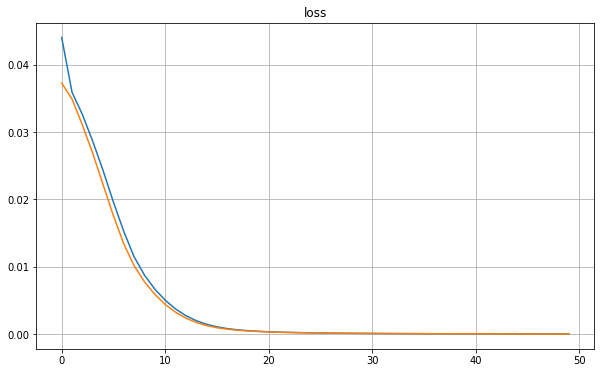

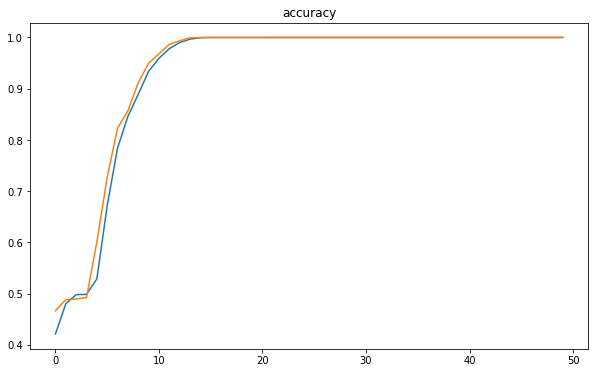

In [155]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

Results:
* **Linear Autoencoder**: loss: 0.0104, accuracy: 94.81%;
* **Non-Linear Autoencoder**: loss: 2.5569e-05, accuracy: 100%;

Using a non-linear activation function should allows us to find a more powerful representation of the important features compared with a linear activation function. This shuold be the reason of the better performances achieved with the non linear model.

I obtained the best preformance by using the tanh as activation function of the LSTM layer and the softmax as activation function of the output layer.

For the activation function of the output layer I choose the _softmax_.
The softmax function converts a vector of values to a probability distribution.
This behavior is exactly the one that we need during the sentence reconstruction procedure, in which the network choose which is the most relevant word to output (the one with the higher associated probability).